In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
base_path = Path("data")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory
kp_selector = "_kp30.0"

save_path = Path(f"outputs/panel{kp_selector}_noadh.pdf")

controller = ["CPG", "Decentralized", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controller]
n_conditions = len(conditions)

sim_time = 1.2
init_time = 0.2
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)

for controller, terrain in conditions:
    for adh in adhesion:
        path = base_path / f"{terrain}_{controller}pts_adhesion{adh}{kp_selector}"
        if not path.is_dir():
            print(f"Path {path} does not exist")
            continue
        all_pkl = list(path.glob("*.pkl"))
        assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
        data_pts = []
        for pkl_file in all_pkl:
            with open(pkl_file, "rb") as f:
                obs_list = pickle.load(f)
            assert len(obs_list) == sim_time * 10_000
            distance = obs_list[-1]["fly"][0][0] - obs_list[0]["fly"][0][0]
            speed = distance / (sim_time - init_time)
            all_rows.append([controller.lower(), terrain.lower(), adh, speed])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed"]
)
speed_df.to_csv("outputs/mean_speed.csv", index=False)

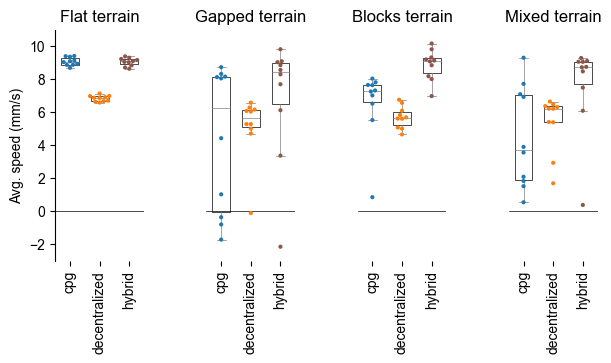

In [6]:
x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("decentralized", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("decentralized", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("decentralized", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(7, 3))
plt.subplots_adjust(wspace=0.7)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")
    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=speed_df[speed_df["terrain"] == terrain_type],
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=speed_df[speed_df["terrain"] == terrain_type],
        hue="controller",
        size=3,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_ylim(-3, 11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if i != 0:
        ax.set_ylabel("")
        ax.set_yticks([])
    else:
        ax.set_ylabel("Avg. speed (mm/s)")
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=i != 0)

plt.savefig("outputs/speed_comparison.pdf", transparent=True)